This notebook is used for comparison of how much similarity is preserved by each method

We will use cosine similarity of our initial dataset as as ground truth

In [132]:
# test size
N = 100000

In [133]:
from random import sample
from time import time
from pickle import dump, load


from IPython.display import clear_output
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_similarity_score
from datasketch import WeightedMinHash, WeightedMinHashGenerator
from scipy.stats import describe

In [134]:
df = pd.read_csv('./dataset.csv', index_col=0)
df_h = pd.read_csv('./neural_hashes.csv', index_col=0)
with open('./sims.pkl', 'rb') as f:
    sims_train_set = load(f)

In [135]:
# test on data that has not been used during training
training_pairs = set()
for movie_name in sims_train_set:
    for pair_type in sims_train_set[movie_name]:
        for movie_subname in sims_train_set[movie_name][pair_type]:
            # for sake of bidirectionality
            training_pairs.add((movie_name, movie_subname))
            training_pairs.add((movie_subname, movie_name))

In [136]:
# generate combinations of movie titles for testing
titles = set(df.index.values)

# genrate weighted minhash gen
wmg = WeightedMinHashGenerator(len(df.columns))

In [137]:
# generate random, shuffled combinations (can't use itertools.combinations for this)
combs = set()
while len(combs) < N:
    pair = tuple(sample(titles, 2))
    if pair not in training_pairs:
        combs.add(pair)

In [138]:
# get similarity score for each representation
gt_cos_arr = np.zeros((N,))
jacc_minhash_arr = np.zeros((N,))
nh_cos_arr = np.zeros((N,))
nh_jacc_arr = np.zeros((N,))

start = time()
for i, comb in enumerate(combs):        
    title_x, title_y = comb
    arr_x = df.loc[title_x].values
    arr_y = df.loc[title_y].values
    
    # ground truth
    gt_cos_arr[i] = cosine_similarity(arr_x.reshape(1, -1), arr_y.reshape(1, -1))[0][0]
    
    # minhash from datasketch
    m_x = wmg.minhash(arr_x)
    m_y = wmg.minhash(arr_y)
    jacc_minhash_arr[i] = m_x.jaccard(m_y)
    
    # neural hashes
    hash_x = df_h.loc[title_x].values
    hash_y = df_h.loc[title_y].values
    nh_cos_arr[i] = cosine_similarity(hash_x.reshape(1, -1), hash_y.reshape(1, -1))[0][0]
    
    nh_jacc_arr[i] = jaccard_similarity_score(hash_x.reshape(1, -1), hash_y.reshape(1, -1))
    
    if i % 100 == 0:
        clear_output()
        print(f'Completed {i}/{N} samples.')
    
print(f'Computing similarity took {time() - start} seconds.')

Completed 99900/100000 samples.
Computing similarity took 1736.6586725711823 seconds.


In [139]:
# serialize results
filenames = ('sim_gt.npy', 'sim_minhash.npy', 'sim_nh_cos.npy', 'sim_nh_jacc.npy')
results = (gt_cos_arr, jacc_minhash_arr, nh_cos_arr, nh_jacc_arr)

for filename, obj in zip(filenames, results):
    with open(filename, 'wb') as f:
        np.save(f, obj)

In [143]:
result = ''
diff_hash_cos = gt_cos_arr - nh_cos_arr
mse_hash_cos = (np.square(diff_hash_cos)).mean()
result += f'MSE for neural hashes using cosine is: {mse_hash_cos}' + '\n'
mae_hash_cos = (np.abs(diff_hash_cos)).mean()
result += f'MAE for neural hashes using cosine is: {mae_hash_cos}' + '\n'
result += 'Diff result: ' + str(describe(diff_hash_cos)) + 2 * '\n'

diff_hash_jacc = gt_cos_arr - nh_jacc_arr
mse_hash_jacc = (np.square(diff_hash_jacc)).mean()
result += f'MSE for neural hashes using jaccard is: {mse_hash_jacc}' + '\n'
mae_hash_jacc = (np.abs(diff_hash_jacc)).mean()
result += f'MAE for neural hashes using jaccard is: {mae_hash_jacc}' + '\n'
result += 'Diff result: ' + str(describe(diff_hash_jacc)) + 2 * '\n'

diff_minhash = gt_cos_arr - jacc_minhash_arr
mse_minhash = (np.square(diff_minhash)).mean()
result += f'MSE for WeightedMinhash from Datasketch is: {mse_minhash}' + '\n'
mae_minhash = (np.abs(diff_minhash)).mean()
result += f'MAE for WeightedMinhash from Datasketch is: {mae_minhash}'
result += 'Diff result: ' + str(describe(diff_minhash)) + 2 * '\n'
print(result)


MSE for neural hashes using cosine is: 0.01762607692681176
MAE for neural hashes using cosine is: 0.10386228439618436
Diff result: DescribeResult(nobs=100000, minmax=(-0.5881907185284916, 0.44559710970232136), mean=-0.01624239125645695, variance=0.0173624352774367, skewness=-0.3100636413185194, kurtosis=0.12109972253118872)

MSE for neural hashes using jaccard is: 0.04063723325228729
MAE for neural hashes using jaccard is: 0.17431659047218073
Diff result: DescribeResult(nobs=100000, minmax=(-0.5782836688711904, 0.594207960271134), mean=0.1338081685842176, variance=0.022732834600770902, skewness=-0.6131884373753338, kurtosis=0.34026608610372344)

MSE for WeightedMinhash from Datasketch is: 0.040800793674588484
MAE for WeightedMinhash from Datasketch is: 0.1966777093038213Diff result: DescribeResult(nobs=100000, minmax=(-0.02244967320794211, 0.39274701678326784), mean=0.19667554634235423, variance=0.0021195443409683574, skewness=-0.019812167378962017, kurtosis=0.14300036981365816)




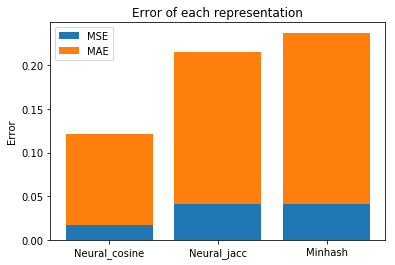

In [163]:
# plot simple bar chart of MSE
objects = ('Neural_cosine', 'Neural_jacc', 'Minhash')
y_pos = np.arange(len(objects))
mse_values = [mse_hash_cos, mse_hash_jacc, mse_minhash]
mae_values = [mae_hash_cos, mae_hash_jacc, mae_minhash]
 
p1 = plt.bar(y_pos, mse_values)
p2 = plt.bar(y_pos, mae_values, bottom=mse_values)
plt.xticks(y_pos, objects)
plt.ylabel('Error')
plt.title('Error of each representation')
plt.legend((p1[0], p2[0]), ('MSE', 'MAE'))
plt.savefig('errors.png')
plt.show()